### ライブラリの準備

###モジュールのインポート

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import datetime
#from tqdm import tqdm
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from collections import deque
from typing import Sequence, Dict, Tuple, Union

import torch
from torch import nn
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import torchvision.datasets as dataset
from torchvision.transforms import v2
import torchvision.transforms as T
from torch.nn.init import constant_, xavier_uniform_, kaiming_uniform_, xavier_normal_, kaiming_normal_

from transformers import  CLIPVisionModel, get_linear_schedule_with_warmup, BertTokenizer

import util
import levenshtein
from nltk import bleu_score
#from cidereval import cider, ciderD

In [2]:
class PositionalEmbedding(nn.Module):
    '''
    位置埋め込み （Positional embedding）
    dim_embedding: 埋込み次元
    max_len      : 入力の最大系列長
    '''
    def __init__(self, dim_embedding: int, max_len: int=2048):
        super().__init__()

        self.pos_emb = nn.Embedding(max_len, dim_embedding)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        positions = torch.arange(start=0, end=seq, step=1, device=x.device ).to(torch.long)
        positions = self.pos_emb(positions)[:seq,:]
        
        return positions

### CaptioningTransformer

In [3]:
class CaptioningTransformer(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    null_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, img_size: int, length_max: int, dim_embedding: int, num_heads: int, 
                 prop_dec_num_layers: int, vocab_size: int, dropout: float = 0.1 ):
        super().__init__()

        #CLIP
        model_id = "openai/clip-vit-large-patch14-336"
        self.clip_model = CLIPVisionModel.from_pretrained(model_id, output_hidden_states = True)
        images = torch.randn( ( 1, 3, img_size, img_size ) )
        memory = self.clip_model( images )
        memory = memory.last_hidden_state
        img_length = memory.size(1)
        clip_dim = memory.size(2)
        
        # Dense Connector
        self.dc_linear = nn.Linear( clip_dim * 3, dim_embedding )
        self.dropout = nn.Dropout( dropout )        
        self.ln_memory = nn.LayerNorm( dim_embedding )

        # Down Sampling
        stride = img_length // ( length_max - 1 )
        self.conv1 = nn.Conv1d( dim_embedding, dim_embedding, 1, stride )
        print( "img_length:", img_length )
        print( "text_length_max:", length_max )
        print( "stride:", stride )
        
        # proper decoder
        self.prop_decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True, norm_first = True, activation='gelu')
            for _ in range(prop_dec_num_layers)
        ])

        self.prop_ln = nn.LayerNorm( dim_embedding )
        # 単語出力分布計算
        self.prop_linear = nn.Linear(dim_embedding, vocab_size)        
        
        #dropout
        self.dropout = nn.Dropout( dropout )
        
        # Others
        self.dim_embedding = dim_embedding
        self.tokenizer = tokenizer
        self._reset_parameters(self)

    def _reset_parameters(self, model ):
        for name, module in model.named_modules():
            #print("name:",name)
            if "clip_model" not in name and "prop_decoder" in name:
                if isinstance( module, nn.Linear ):
                    #print("name1:", name )
                    for name, p in module.named_parameters():
                        xavier_uniform_(module.weight)
                        nn.init.zeros_(module.bias)
                        #if name == "weight":
                            #print( "name2:", name)
                            #xavier_uniform_(p)
                            #xavier_normal_(p)
                            #kaiming_uniform_(p)
                            #kaiming_normal_(p)
                            #nn.init.normal_(p, mean=0.0, std=0.02)
                        #elif name == "bias":
                        #    nn.init.zeros_(p)
                elif isinstance( module, nn.Embedding):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                elif isinstance(module, nn.LayerNorm):
                    nn.init.zeros_(module.bias)
                    nn.init.ones_(module.weight)  
            elif "clip_model" not in name and "aux_decoder" in name:
                if isinstance( module, nn.Linear ):
                    #print("name1:", name )
                    for name, p in module.named_parameters():
                        xavier_uniform_(module.weight)
                        nn.init.zeros_(module.bias)
                        #if name == "weight":
                            #print( "name2:", name)
                            #xavier_uniform_(p)
                            #xavier_normal_(p)
                            #kaiming_uniform_(p)
                            #kaiming_normal_(p)
                            #nn.init.normal_(p, mean=0.0, std=0.02)
                        #elif name == "bias":
                        #    nn.init.zeros_(p)
                elif isinstance( module, nn.Embedding):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                elif isinstance(module, nn.LayerNorm):
                    nn.init.zeros_(module.bias)
                    nn.init.ones_(module.weight)  
    
            #if isinstance(module, nn.Linear):
            #    nn.init.normal_(module.weight, mean=0.0, std=0.02)
            #    if module.bias is not None:
            #        nn.init.zeros_(module.bias)
            #elif isinstance(module, nn.Embedding):
            #    nn.init.normal_(module.weight, mean=0.0, std=0.02)
            #elif isinstance(module, nn.LayerNorm):
            #    nn.init.zeros_(module.bias)
            #    nn.init.ones_(module.weight)  

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]
    '''
    def forward(self, images: torch.Tensor ):

        self.device = images.device

        memory = self.clip_model( images )
        memory = self.dense_connector( memory )
        memory = self.dropout( memory )
        memory = self.ln_memory( memory )

        tgt = self.conv1( memory.transpose(1,2) ).transpose(1,2)
       
        # ctc loss 計算のため
        for layer in self.prop_decoder_layers:
            tgt = layer( tgt, memory, tgt_mask = None, tgt_key_padding_mask = None, 
                       memory_key_padding_mask = None, tgt_is_causal = False )        

            
        # 単語出力分布計算
        tgt = self.prop_ln( tgt )
        logits = self.prop_linear( tgt )

        return logits

    def dense_connector(self, memory ):
        tmp1 = torch.tensor([], device = self.device  )
        tmp2 = torch.tensor([], device = self.device  )
        tmp_full = len( memory.hidden_states )
        tmp_half = tmp_full // 2
        for i in range( 0, tmp_half ):
            tmp1 = torch.cat( [tmp1, memory.hidden_states[i][None]], dim = 0 )
        tmp1 = torch.sum(tmp1, dim=0) / tmp_half
        for i in range( tmp_half, tmp_full ):
            tmp2 = torch.cat( [tmp2, memory.hidden_states[i][None]], dim = 0 )
        tmp2 = torch.sum(tmp2, dim=0 ) / ( tmp_full - tmp_half )
        tmp3 = torch.cat([tmp1, tmp2], dim=-1)
        tmp3 = torch.cat( [ memory.last_hidden_state, tmp3], dim = -1 )
        tmp3 = self.dc_linear( tmp3 )
        return tmp3

    def my_decode(self, token_list, tokenizer ):

        def my_index( l, x ):
            if x in l:
                return l.index(x)
            else:
                return -1
        if my_index( token_list, tokenizer.sep_token_id ) != -1:
            token_list = token_list[:my_index( token_list, tokenizer.sep_token_id )]
        else:
            token_list = token_list
            
        text = tokenizer.decode( token_list, skip_special_tokens = True )
        
        return text
        
    '''
    def dense_connector(self, memory ):
        tmp = torch.zeros_like( memory.hidden_states[0] )
        for tmp1 in memory.hidden_states:
            tmp += tmp1
        tmp += memory.last_hidden_state
        tmp /= (len( memory.hidden_states) + 1 )

        tmp = self.dc_linear( tmp )

        return tmp
    '''

In [4]:
class MyDataset(Dataset):
    def __init__(self, file_path: str, img_directory: str, transforms, tokenizer, length_max = None ) -> None:
        super().__init__()
        self.img_directory = img_directory
        self.transforms = transforms
        # TODO: fix to original data
        #画像の前処理
        self.img_file = []
        self.tokens = []
        if length_max == None:
            self.length_max = 0
        else:
            self.length_max = length_max
        length_sum = 0
        with open( file_path, "r" ) as f:
            #line = f.readline()
            #i = 0
            #while line:
            for i, line in enumerate( f ):
                if i % 100000 == 0:
                #    #print( line.split("\t")[0])
                #    #print( line.split("\t")[1])
                    print( "i:", i )
                #i += 1
                self.img_file.append(line.split("\t" )[0])
                caption = line.split("\t")[1].replace( "\r\n", "" ).replace( "\n", "").replace( "\r", "" )
                #print( "caption:", caption )
                id_tokens = tokenizer.encode( caption )
                length_sum += len( id_tokens )
                if length_max == None:
                    if self.length_max < len( id_tokens ):
                        self.length_max = len( id_tokens )
                    id_tokens = torch.tensor( id_tokens, requires_grad = False  )
                else:
                    id_tokens = torch.tensor( id_tokens, requires_grad = False)[:length_max]
                    
                #print( "id_tokens:", id_tokens )
                self.tokens.append( id_tokens )

                #line = f.readline()
        print("avg len:", length_sum / len( self.tokens ) )    
    
    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index: int
    ):
        tokens = self.tokens[index]
        img_file = self.img_file[index] + ".jpg"
        img_path = os.path.join( self.img_directory, img_file ) #index番目の画像のパスを取得
        img = Image.open(img_path) #PIL形式で画像を読み込み
        if img.mode != 'RGB':
            img = img.convert("RGB")
        img = self.transforms(img)
        
        return img, tokens

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.tokens)

    def length_max(self):
        return self.length_max

In [5]:
def collate_func(batch: Sequence[Tuple[Union[torch.Tensor, str]]], pad_index ):
    imgs, tokens = zip(*batch)

    max_length = 0
    for target in tokens:
        if max_length < len( target ):
            max_length = len( target )
    
    targets = []
    lengths = []
    for target in tokens:
        pad_len = max_length - len( target ) 
        #print( "target:", target )
        input2= F.pad( target, (0, pad_len), mode='constant', value = pad_index)
        targets.append( input2 )
        lengths.append( len( target ) )
    
    imgs = torch.stack( imgs, dim = 0 )
    targets = torch.stack( targets, dim = 0 )
    lengths = torch.tensor( lengths, requires_grad = False  )

    #if imgs.dim() != 4:
    #   print( "in collate imgs size:", imgs.size() )
    
    return imgs, targets, lengths

In [6]:
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank token_id:", blank_token_id )

caption = "Hello World!".lower()
token_ids = tokenizer.encode( caption )
print( token_ids )
#decoded = tokenizer.tokenize( token_ids )
#print( decoded )
decoded = tokenizer.decode( token_ids )
print( decoded )
#print( tokenizer.tokenize( decoded ) )
#individual_decoded_tokens = list(map(tokenizer.decode, token_ids))
individual_decoded_tokens = [tokenizer.decode( [token], skip_special_tokens = True ) for token in token_ids ]
individual_decoded_tokens2 = [tokens for tokens in individual_decoded_tokens if tokens != '' ]
print( individual_decoded_tokens2 )

/home/uchiyats/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


blank token_id: 1
[101, 7592, 2088, 999, 102]


2025-09-25 04:02:00.513438: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 04:02:00.534342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758740520.549511   25858 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758740520.554355   25858 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758740520.568606   25858 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[CLS] hello world! [SEP]
['hello', 'world', '!']


blank  token_id: 1
i: 0
i: 100000
i: 200000
i: 300000
i: 400000
i: 500000
avg len: 42.0877771734418
train_dataset.length_max: 294
torch.Size([4, 56])
torch.Size([4, 3, 336, 336])


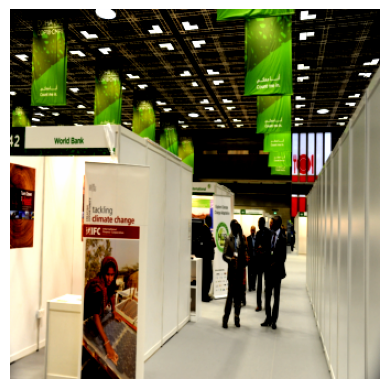

In [8]:
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank  token_id:", blank_token_id )
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id)

# 画像のtransformsを定義
transforms = v2.Compose([
    v2.Resize((336, 336)),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.AutoAugment(),
    ## Coco データセット 2017 train の平均と標準偏差
    #v2.Normalize((0.456,0.427,0.401),(0.224,0.219,0.231) )
    # Clip Model の config から引用。
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])



# v7 データセット
train_dataset = MyDataset( file_path="../CLIP_LLM_AR/dataset.txt",
                           img_directory = "/mnt/ssd2/v7/img",
                           transforms=transforms, tokenizer = tokenizer, length_max = None )

print( "train_dataset.length_max:", train_dataset.length_max )

# Subset samplerの生成
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, 0.1, 0.1 )
    
# 学習時にランダムにサンプルするためのサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id )
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=4,
                    num_workers=0,
                    shuffle = False,
                    #sampler=train_sampler,
                    pin_memory = True,
                    collate_fn=collate_func_lambda)
transforms_inv = v2.Compose([
    v2.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954,1/0.26130258,1/0.27577711)),
    v2.ToPILImage()
])

#for n, (imgs, targets, lengths) in enumerate( train_loader ):
#    #print( "imgs size:", imgs.size())
#    if n % 100 == 0:
#        print( "n:", n )
    
imgs, targets, lengths = next(iter(train_loader))

##print( targets )
print( targets.size() )
print( imgs.size() )
##print( imgs[0] )
##img[0].show()
inv_img = transforms_inv( imgs[0] )
plt.imshow( inv_img )
plt.axis('off')
plt.show()

###学習におけるハイパーパラメータやオプションの設定

In [6]:
class ConfigTrain(object):
    '''
    ハイパーパラメータ、システム共通変数の設定
    '''
    def __init__(self):

        # ハイパーパラメータ
        self.img_size = 336
        self.dim_embedding = 1280   # 埋め込み層の次元
        #self.dim_embedding = 1024   # 埋め込み層の次元
        #self.num_heads = 16
        self.num_heads = 20
        #self.prop_dec_num_layers = 24
        self.prop_dec_num_layers = 36
        self.length_max = 97
        #self.lr = 5e-5            # 学習率
        #self.lr = 2e-5            # 学習率
        #self.lr = 1e-5            # 学習率
        #self.lr = 2e-6            # 学習率
        #self.lr = 1e-6            # 学習率
        #self.lr = 5e-7            # 学習率
        self.lr_clip = 2e-7            # 学習率
        self.lr_prop_decoder = 1e-4            # 学習率
        self.lr_others = 1e-4
        self.dropout = 0.1
        #self.batch_size = 128       # ミニバッチ数
        #self.batch_size = 16       # ミニバッチ数
        self.batch_size = 12       # ミニバッチ数
        #self.batch_size = 8       # ミニバッチ数
        #self.batch_size = 6       # ミニバッチ数
        #self.batch_size = 4       # ミニバッチ数
        #self.batch_size = 2       # ミニバッチ数
        #self.num_epochs = 100       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        #self.num_epochs = 60       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        self.num_epochs = 10       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        #self.num_epochs = 5       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        self.use_amp = True
        #self.use_amp = False
        #self.use_saved_pth = True
        self.use_saved_pth = False
        self.vocab_size = len( tokenizer )
        self.weight_decay = 0.1
        self.betas = (0.9, 0.999 )
        self.warmup = 0.1

        # パスの設定
        self.img_directory = '/mnt/ssd2/v7/img'
        self.anno_file = '../CLIP_LLM_AR/dataset.txt'
        self.save_directory = './model'

        # 検証に使う学習セット内のデータの割合
        self.test_ratio = 0.1
        self.val_ratio = 0.1
        #self.val_ratio = 0.0004
        #self.test_ratio = 0.0004
        
        # 学習に使うデバイス
        #self.device = 'cuda'
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #self.device = 'cpu'
        
        # データローダーに使うCPUプロセスの数
        #self.num_workers = 4
        self.num_workers = 0 if self.device == torch.device('cpu') else 8
        #self.num_workers = 0 if self.device == torch.device('cpu') else 6
        #self.num_workers = 0
        
        # 移動平均で計算する損失の値の数
        self.moving_avg = 100

In [17]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank token_id:", blank_token_id )
model = CaptioningTransformer( img_size = 336, length_max = 97, dim_embedding=1280, num_heads = 16, \
                               prop_dec_num_layers = 12, vocab_size = len( tokenizer), dropout = 0.1 ).to(device)
images = torch.randn( ( 2, 3, 336,336 ), device = device )
logits = model( images )

print( logits.size() )

blank token_id: 1
img_length: 577
text_length_max: 97
stride: 6
torch.Size([2, 97, 30522])


### 学習を行う

In [7]:
def ctc_simple_decode(int_vector, tokenizer):
    ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
        1. 同じ文字が連続して出現する場合は削除
        2. blank を削除
    int_vector: フレーム単位のCTC出力(整数値列)
    token_list: トークンリスト
    output:     トークン列
    '''
    # 出力文字列
    output = []
    # 一つ前フレームの文字番号
    prev_token = -1
    # フレーム毎の出力文字系列を前から順番にチェックしていく
    for n in int_vector:
        n = n.item()
        if n != prev_token:
            # 1. 前フレームと同じトークンではない
            if n != tokenizer.encode( [ "[unused0]"] )[1] and n != tokenizer.encode( [ "[CLS]"] )[1] \
                and n != tokenizer.encode( [ "[SEP]"] )[1] and n != tokenizer.encode( [ "[PAD]"] )[1]:
                # 2. かつ，blank(番号=0)ではない
                # --> token_listから対応する文字を抽出し，
                #     出力文字列に加える
                output.append( tokenizer.decode( [n] ) )
            # 前フレームのトークンを更新
            prev_token = n
        if n == tokenizer.encode( ["[SEP]"] )[1]:
            break
    return output

In [8]:
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank token_id:", blank_token_id )

config = ConfigTrain()

print( "use_amp:", config.use_amp )

# モデル出力用のディレクトリを作成
os.makedirs(config.save_directory, exist_ok=True)

# 画像のtransformsを定義
transforms = v2.Compose([
    v2.Resize((config.img_size, config.img_size)),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.AutoAugment(),
    ## Coco データセット 2017 train の平均と標準偏差
    #v2.Normalize((0.456,0.427,0.401),(0.224,0.219,0.231) )
    # Clip Model の config から引用。
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# v7 データセット
train_dataset = MyDataset( file_path=config.anno_file,
                           img_directory = config.img_directory,
                           transforms=transforms,tokenizer=tokenizer, length_max = config.length_max)

# Subset samplerの生成
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, config.test_ratio, config.val_ratio )
    
# 学習時にランダムにサンプルするためのサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id)
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=config.batch_size,
                    num_workers=config.num_workers,
                    sampler=train_sampler,
                    collate_fn=collate_func_lambda)

val_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=config.batch_size,
                    num_workers=config.num_workers,
                    sampler=val_set,
                    collate_fn=collate_func_lambda)

test_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    #batch_size=config.batch_size,
                    batch_size=1,
                    num_workers=config.num_workers,
                    sampler=test_set,
                    collate_fn=collate_func_lambda)


print( "device:", config.device )
print( "学習セット数:",len( train_loader ) )
print( "評価セット数:",len( val_loader ))
print( "テストセット数:",len( test_loader ))
    
# モデルの定義
model = CaptioningTransformer( config.img_size, train_dataset.length_max, config.dim_embedding, config.num_heads, 
                               config.prop_dec_num_layers, len(tokenizer), config.dropout )
model = model.to(config.device) 

# 損失関数の定義
ctc_criterion = nn.CTCLoss(blank=blank_token_id, reduction='mean',zero_infinity=True) 

# 最適化手法の定義
# Optimizerの生成, clipとそうでないモジュールとの
# パラメータで異なる学習率を適用
params_clip = []
params_prop_decoder = []
params_others = []
for name, parameter in model.named_parameters():
    if parameter.requires_grad:
        if 'clip_model' in name:
            params_clip.append(parameter)
        elif 'prop_decoder' in name:
            params_prop_decoder.append(parameter)
        else:
            params_others.append(parameter)
param_groups = [
    {'params': params_clip, 'lr': config.lr_clip},
    {'params': params_prop_decoder, 'lr': config.lr_prop_decoder},
    {'params': params_others, 'lr': config.lr_others}]
#optimizer = torch.optim.AdamW( model.parameters() , lr=config.lr)
optimizer = torch.optim.AdamW( param_groups, weight_decay = config.weight_decay, betas=config.betas )

# 全ステップ数
num_global_steps = len( train_loader ) * config.num_epochs
print( "num_global_steps:", num_global_steps )
num_warmup_steps = num_global_steps * config.warmup
print( "num_warmup_steps:", num_warmup_steps )
#スケジューラーの定義
scheduler = get_linear_schedule_with_warmup( optimizer, num_warmup_steps, num_global_steps )    

PATH = f'{config.save_directory}/model_clip_decoder0_nar_curr.pth'
print( "use_saved_pth:", config.use_saved_pth )
print( "exist saved_pth:", os.path.isfile(PATH) ) 
if config.use_saved_pth and os.path.isfile(PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    ##device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ## optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
    #for state in optimizer.state.values():
        #for k, v in state.items():
            #if isinstance(v, torch.Tensor):
                #state[k] = v.to(device)
    begin_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    global_step = checkpoint['global_step']
else:
    begin_epoch = 0
    global_step = 0

print( "begin_epoch:", begin_epoch )
print( "global_step:", global_step )
    
len_tr_loader = len( train_loader )
train_param = len_tr_loader // 3
len_val_loader = len( val_loader )
#train_param = len_val_loader // 3
val_param = len_val_loader // 3
print( "train_param:", train_param )
print( "val_param:", val_param )

print( "epochs:", config.num_epochs )
print( "batch_size:", config.batch_size )
print( "lr_clip:", config.lr_clip )
print( "lr_prop_decoder:", config.lr_prop_decoder )
print( "lr_others:", config.lr_others )
print( "weight_decay:", config.weight_decay )
print( "betas:", config.betas )
print( "warmup:", config.warmup )

# 学習経過の書き込み
now = datetime.datetime.now()
train_loss_file = '{}/MyOriginal_train_loss_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
with open(train_loss_file, 'a') as f:
    print(f'{len_tr_loader}', file=f)
print( "train_loss_file:", train_loss_file )
val_loss_file = '{}/MyOriginal_val_loss_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
with open(val_loss_file, 'a') as f:
    print(f'{len_val_loader}', file=f) 
norm_file = '{}/norm_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))

# 学習
val_loss_best = float('inf')

fn = bleu_score.SmoothingFunction().method7

# AMP用のスケーラー
scaler = GradScaler(enabled=config.use_amp)

for epoch in range(begin_epoch, config.num_epochs):
    with tqdm(train_loader) as pbar:
    #with tqdm(val_loader) as pbar:
        pbar.set_description(f'[エポック {epoch + 1}]')

        # 学習モードに設定
        model.train()

        train_losses = deque()
        train_errors = deque()
        train_bleus = deque()
        #train_ciders = deque()
        for n_batch, (imgs, captions, caption_lengths) in enumerate( pbar ):
            # ミニバッチを設定
            imgs = imgs.to(config.device)
            captions = captions.to(config.device)
            caption_lengths = caption_lengths.to(config.device)
                
            optimizer.zero_grad()

            with autocast(str(config.device),enabled=config.use_amp):
                # 最後の単語から次を予測する必要はないため最後の単語を除外
                ctc_logits = model(imgs )
                hypo_ids = torch.argmax( ctc_logits, dim = 2 )
                ctc_outputs_lengths = torch.full( size = (ctc_logits.size(0), ), fill_value = ctc_logits.size(1), dtype=torch.long)
                ctc_outputs = F.log_softmax( ctc_logits, dim=2 )

                # 損失の計算
                # 単語軸が第1軸である必要があるため、転置
                loss = ctc_criterion(ctc_outputs.transpose(0, 1),captions,ctc_outputs_lengths,caption_lengths)

            # 誤差逆伝播
            scaler.scale(loss).backward()
            #scaler.unscale_(optimizer)
            #clip_grad_threshold = 5.0
            #torch.nn.utils.clip_grad_norm_(\
            #        model.parameters(),
            #        clip_grad_threshold)
            # オプティマイザにより，パラメータを更新する
            scaler.step(optimizer)
            scaler.update()            
            
            scheduler.step()

            #for name, param in model.named_parameters():
            #    print( name )
            # 勾配消失が起こっていないか監視
            norm0 = torch.sqrt( torch.norm( model.clip_model.vision_model.encoder.layers[0].self_attn.q_proj.weight.grad, p = 2 ) ).item()
            norm1 = torch.sqrt( torch.norm( model.prop_decoder_layers[35].self_attn.in_proj_weight.grad, p = 2 ) ).item()
            norm_mean = torch.mean( torch.stack ([ torch.sqrt( torch.norm( param.grad, p = 2 ) ) \
                                                  for param in model.parameters() if param.grad is not None ] ) ).item()
            with open(norm_file, 'a') as f:
                print( "epcoch:", epoch, ", step:", global_step, ", norm0:", norm0, ", norm1:", norm1, ", norm_mean:", norm_mean, file=f  )
                f.flush()
            global_step += 1

            n = 0
            hypo_sentence = []
            ref_sentence = []
            hypo_sentence1 = []
            ref_sentence1 = []
            total_error = 0
            total_token_length = 0
            total_bleu = 0
            #total_cider = 0
            n2 = 0
            for n3, (hypo_id, caption) in enumerate( zip( hypo_ids, captions )):
                #print( "n_batch:", n_batch, " n3:", n3, "caption:", caption )
                hypo_tokens = ctc_simple_decode(hypo_id, tokenizer)
                hypo = ' '.join( hypo_tokens )
                reference = tokenizer.decode( caption.tolist(), skip_special_tokens = True )
                ref_tokens = tokenizer.tokenize( reference )
                #print( "hypo_tokens:", hypo_tokens )
                #print( "ref_tokens:", ref_tokens )
                
                # 認識誤りを計算
                (error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo_tokens,ref_tokens)
                # 誤り文字数を累積する
                total_error += error
                # 文字の総数を累積する
                total_token_length += ref_length

                bleu = bleu_score.sentence_bleu( [reference], hypo, smoothing_function=fn  )
                #cider_ = cider(predictions=[hypo], references=[[reference]])['avg_score']
        
                total_bleu += bleu
                #total_cider += cider_
                
                if n < 1 and n_batch == len( train_loader ) - 1 :
                #if n < 1 and n_batch == len( val_loader ) - 1 :
                    hypo_sentence.append( hypo )
                    ref_sentence.append( reference )
                if n < 1 and n_batch % train_param == 0:
                    hypo_sentence1.append( hypo )
                    ref_sentence1.append( reference )
                    
                n += 1
                n2 += 1
            
            avg_error = total_error / total_token_length * 100
            avg_bleu = total_bleu / n2 * 100
            #avg_cider = total_cider / n2
            
            # 学習時の損失をログに書き込み
            train_losses.append(loss.item())
            train_errors.append( avg_error )
            train_bleus.append( avg_bleu )
            #train_ciders.append( avg_cider )
            if len(train_losses) > config.moving_avg:
                train_losses.popleft()
                train_errors.popleft()
                train_bleus.popleft()
                #train_ciders.popleft()
            mean_loss = torch.Tensor(train_losses).mean().item()
            mean_error = torch.Tensor(train_errors).mean().item()
            mean_bleu = torch.Tensor(train_bleus).mean().item()
            pbar.set_postfix({
                'loss': mean_loss,
                'WER': mean_error,
                'BLEU': mean_bleu,
                #'CIDER': torch.Tensor(train_ciders).mean().item()
            })
            with open(train_loss_file, 'a') as f:
                #print(f'{epoch}, {loss.item()},  {avg_error}, {avg_bleu}, {avg_cider}', file=f)
                print(f'{epoch}, {mean_loss}, {mean_error}, {mean_bleu}', file=f)
            print_flag = 1
            for ( hypo_se, ref_se ) in zip( hypo_sentence1, ref_sentence1 ):
                if print_flag == 1:
                    print( "lr_clip  :", optimizer.param_groups[0]["lr"] )
                    print( "lr_prop_decoder:", optimizer.param_groups[1]["lr"] )
                    print( "lr_others:", optimizer.param_groups[2]["lr"] )
                    print_flag = 0
                #print(f'Train epoch = {epoch}, loss = {loss.item()}, WER = {avg_error}, BLEU = {avg_bleu}, CIDER = {avg_cider}')
                print(f'Train epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print(f'Train epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                #print(f'Train epoch = {epoch}, loss = {loss.item()}, WER = {avg_error}, BLEU = {avg_bleu}, CIDER = {avg_cider}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )

    # 学習率を表示
    print(f"学習率 clip,         param_groups:", optimizer.param_groups[0]["lr"] )
    print(f"学習率 prop_decoder, param_groups:", optimizer.param_groups[1]["lr"] )
    print(f"学習率 others,       param_groups:", optimizer.param_groups[2]["lr"] )
    train_loss = np.mean(train_losses)
    train_error = np.mean(train_errors )
    train_bleu = np.mean(train_bleus )
    #train_cider = np.mean(train_ciders )
    print(f'Train loss: {train_loss}')
    print(f'Train WER: {train_error}')        
    print(f'Train BLEU: {train_bleu}')
    #print(f'Train CIDER: {train_cider}')

    # 検証
    with tqdm(val_loader) as pbar:
        pbar.set_description(f'[検証]')

        # 評価モード
        model.eval()

        val_losses = deque()
        val_errors = deque()
        val_bleus = deque()
        #val_ciders = deque()
        for n_batch, (imgs, captions, caption_lengths) in enumerate( pbar ):

            # ミニバッチを設定
            imgs = imgs.to(config.device)
            captions = captions.to(config.device)
            caption_lengths = caption_lengths.to(config.device)
                
            with torch.no_grad():
                ctc_logits = model(imgs )
                hypo_ids = torch.argmax( ctc_logits, dim = 2 )
                ctc_outputs_lengths = torch.full( size = (ctc_logits.size(0), ), fill_value = ctc_logits.size(1), dtype=torch.long)
                ctc_outputs = F.log_softmax( ctc_logits, dim=2 )

                # 損失の計算
                # 単語軸が第1軸である必要があるため、転置
                loss = ctc_criterion(ctc_outputs.transpose(0, 1),captions,ctc_outputs_lengths,caption_lengths)

            val_losses.append(loss.item())

            n = 0
            hypo_sentence = []
            ref_sentence = []
            hypo_sentence1 = []
            ref_sentence1 = []
            total_error = 0
            total_token_length = 0
            total_bleu = 0
            #total_cider = 0
            n2 = 0
            for (hypo_id, caption) in zip( hypo_ids, captions ):
                hypo_tokens = ctc_simple_decode(hypo_id, tokenizer)
                hypo = ' '.join( hypo_tokens )
                reference = tokenizer.decode( caption.tolist(), skip_special_tokens = True )
                ref_tokens = tokenizer.tokenize( reference )
                # 認識誤りを計算
                (error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo_tokens, ref_tokens)
                    
                # 誤り文字数を累積する
                total_error += error
                # 文字の総数を累積する
                total_token_length += ref_length

                bleu = bleu_score.sentence_bleu( [reference], hypo, smoothing_function=fn  )
                #cider_ = cider(predictions=[hypo], references=[[reference]])['avg_score']
        
                total_bleu += bleu
                #total_cider += cider_
                #print("hypo:", ' '.join(hypo))

                if n < 1 and n_batch == len( val_loader ) - 1:
                    hypo_sentence.append( hypo )
                    ref_sentence.append( reference )
                        
                if n < 1 and n_batch % val_param == 0:
                    hypo_sentence1.append( hypo )
                    ref_sentence1.append( reference )
                    
                n += 1
                n2 += 1
                
            avg_error = total_error / total_token_length * 100                    
            avg_bleu = total_bleu / n2 * 100
            #avg_cider = total_cider / n2

            # 学習時の損失をログに書き込み
            val_losses.append(loss.item())
            val_errors.append( avg_error )
            val_bleus.append( avg_bleu )
            if len(val_losses) > config.moving_avg:
                val_losses.popleft()
                val_errors.popleft()
                val_bleus.popleft()
            mean_loss = torch.Tensor(val_losses).mean().item()
            mean_error = torch.Tensor(val_errors).mean().item()
            mean_bleu = torch.Tensor(val_bleus).mean().item()
            pbar.set_postfix({
                'loss': mean_loss,
                'WER': mean_error,
                'BLEU': mean_bleu,
            })
            # Validation Lossをログに書き込み
            with open(val_loss_file, 'a') as f:
                print(f'{epoch}, {mean_loss},  {mean_error}, {mean_bleu}', file=f)

            for ( hypo_se, ref_se ) in zip( hypo_sentence1, ref_sentence1 ):
                print(f'Val epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print(f'Val epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )

    # Loss 表示
    val_loss = np.mean(val_losses)
    val_error = np.mean( val_errors )
    val_bleu = np.mean( val_bleus )
    #val_cider = np.mean( val_ciders )
    print(f'Validation loss: {val_loss}')
    print(f'Validation WER: {val_error}')
    print(f'Validation BLEU: {val_bleu}')
    #print(f'Validation CIDER: {val_cider}')

    # より良い検証結果が得られた場合、モデルを保存
    if val_loss < val_loss_best:
        val_loss_best = val_loss

        # モデルを保存
        torch.save({'epoch': epoch,
                    'global_step': global_step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss,},
            f'{config.save_directory}/model_clip_decoder0_nar_best.pth')
            
    # モデルを保存
    torch.save({'epoch': epoch,
                'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,},
        f'{config.save_directory}/model_clip_decoder0_nar_curr.pth')
        
# モデルを保存
torch.save({'epoch': epoch,
    'global_step': global_step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss,},
    f'{config.save_directory}/model_clip_decoder0_nar_final.pth')

/home/uchiyats/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


blank token_id: 1
use_amp: True
i: 0
i: 100000
i: 200000
i: 300000
i: 400000
i: 500000
avg len: 42.0877771734418
device: cuda:0
学習セット数: 33830
評価セット数: 4229
テストセット数: 50744
img_length: 577
text_length_max: 97
stride: 6
num_global_steps: 338300
num_warmup_steps: 33830.0
use_saved_pth: False
exist saved_pth: True
begin_epoch: 0
global_step: 0
train_param: 11276
val_param: 1409
epochs: 10
batch_size: 12
lr_clip: 2e-07
lr_prop_decoder: 0.0001
lr_others: 0.0001
weight_decay: 0.1
betas: (0.9, 0.999)
warmup: 0.1
train_loss_file: ./model/MyOriginal_train_loss_20250925_040916.csv


  0%|          | 0/33830 [00:00<?, ?it/s]

/home/uchiyats/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
2025-09-25 04:09:20.582412: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 04:09:20.603765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000

lr_clip  : 5.911912503694945e-12
lr_prop_decoder: 2.9559562518474726e-09
lr_others: 2.9559562518474726e-09
Train epoch = 0, loss = 24.086944580078125, WER = 215.4296875, BLEU = 14.723499298095703
refe: here in this picture we can see a church with door and windows present over a place and in front of it we can see number of graves with grave stones present on the ground and we can see the ground is fully covered with grass and we can also see plants and trees present and we can see the sky is cloudy.
hypo: alsace coping unanimously nmi pensacola gym enabled toby lithuania toby bicycles lithuania nmi https engraved [unused977] ##ailed forgot toby minorities ##ailed enabled ##„ regulation [unused977] ##\ ##oft ##ailed nmi gym magnolia toby sabotage lithuania gym and ##oft https ##ailed peat plumage hawks sabre gym [unused977] gym lithuania toby sen ##ailed gym minorities nmi gym enrichment lithuania nmi unanimously shaking ##ailed enrichment ##ailed gym unanimously ##ᵘ [unused84] gym lev

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 0, loss = 2.8990883827209473, WER = 78.60082244873047, BLEU = 7.419482231140137
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants . are buildings sky .
Val epoch = 0, loss = 3.1615188121795654, WER = 82.09595489501953, BLEU = 13.746201515197754
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this picture we can see .
Val epoch = 0, loss = 3.1836495399475098, WER = 81.7984619140625, BLEU = 14.166268348693848
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see buildings . lights .
Val epoch = 0, loss = 3.1717023849487305, WER = 80.77240753173828, BLEU = 15.367867469787598
refe: in this image i can see buildings, framed glass wall, stairs, tr

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.9999934312083292e-07
lr_prop_decoder: 9.999967156041646e-05
lr_others: 9.999967156041646e-05
Train epoch = 1, loss = 3.0833473205566406, WER = 82.94242858886719, BLEU = 13.33527660369873
refe: this is a black and white image. in the center of the image we can see a man. on the right side the image is dark.
hypo: in this image can see a person .
lr_clip  : 1.925923736328702e-07
lr_prop_decoder: 9.629618681643513e-05
lr_others: 9.629618681643513e-05
Train epoch = 1, loss = 3.125425100326538, WER = 79.44315338134766, BLEU = 17.854839324951172
refe: there are some people standing. in that there are students and they are holding a trophy. in the back there is a banner. in the background there is a window and a wall.
hypo: in this image we can see holding trophy . the background there see a banner wall .
lr_clip  : 1.8518540414490752e-07
lr_prop_decoder: 9.259270207245377e-05
lr_others: 9.259270207245377e-05
Train epoch = 1, loss = 3.0618176460266113, WER = 78.75851440429688, BL

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 1, loss = 2.764667272567749, WER = 75.9259262084961, BLEU = 13.072299003601074
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants plants . the see buildings and the sky .
Val epoch = 1, loss = 3.0720338821411133, WER = 77.74800872802734, BLEU = 21.3453426361084
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see leaves . .
Val epoch = 1, loss = 3.090475559234619, WER = 77.55742645263672, BLEU = 21.766477584838867
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water lights , are buildings and the is sky .
Val epoch = 1, loss = 3.0775437355041504, WER = 77.17898559570312, BLEU = 22.247438430786133
refe: in this image i 

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.777771208986107e-07
lr_prop_decoder: 8.888856044930535e-05
lr_others: 8.888856044930535e-05
Train epoch = 2, loss = 2.9988515377044678, WER = 72.26107025146484, BLEU = 26.97394561767578
refe: in this picture we can see few people, among them we can see a woman is holding mike, another person playing guitar, side some people are in the shed.
hypo: in this image there can a people playing a musical . the there see a sky .
lr_clip  : 1.70370151410648e-07
lr_prop_decoder: 8.518507570532401e-05
lr_others: 8.518507570532401e-05
Train epoch = 2, loss = 3.0601389408111572, WER = 78.66506958007812, BLEU = 19.3194580078125
refe: in this image we can see one big machine, some chairs and some text paper attached to the machine.
hypo: in this image we can see a metal .
lr_clip  : 1.6296318192268532e-07
lr_prop_decoder: 8.148159096134267e-05
lr_others: 8.148159096134267e-05
Train epoch = 2, loss = 3.00862193107605, WER = 78.47283935546875, BLEU = 18.880266189575195
refe: in this image i

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 2, loss = 2.7541797161102295, WER = 74.27983856201172, BLEU = 13.426798820495605
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants , there are trees and the sky .
Val epoch = 2, loss = 3.0440468788146973, WER = 78.86689758300781, BLEU = 18.76197624206543
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see leaves .
Val epoch = 2, loss = 3.066657543182373, WER = 78.30992889404297, BLEU = 19.853286743164062
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water . there are buildings and sky .
Val epoch = 2, loss = 3.0526530742645264, WER = 77.7831802368164, BLEU = 20.61066246032715
refe: in this image i can see buildings,

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.5555489867638846e-07
lr_prop_decoder: 7.777744933819424e-05
lr_others: 7.777744933819424e-05
Train epoch = 3, loss = 2.756898880004883, WER = 75.22935485839844, BLEU = 21.924278259277344
refe: in this image there is a photo on a paper, there is text on a paper, there is a person sitting on the chair, there is a table, there are objects on the table, there is a cloth truncated behind the person.
hypo: in this image we can see a photo a .
lr_clip  : 1.4814792918842578e-07
lr_prop_decoder: 7.40739645942129e-05
lr_others: 7.40739645942129e-05
Train epoch = 3, loss = 3.043043851852417, WER = 78.3431625366211, BLEU = 19.344886779785156
refe: this image is clicked in a room. there are four people in this image. in the middle, there is a empty bench. to the left, the man is standing. in the background there is a ventilator and a poster on the wall. at the top, there is a slab and light on it.
hypo: in this image we can people sitting on the bench a there is a lights .
lr_clip  : 1

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 3, loss = 2.7275452613830566, WER = 74.8971176147461, BLEU = 16.468978881835938
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants trees . there are trees , sky .
Val epoch = 3, loss = 3.0321691036224365, WER = 79.10787200927734, BLEU = 18.714523315429688
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see leaves . is blur .
Val epoch = 3, loss = 3.0503551959991455, WER = 78.96936798095703, BLEU = 19.0412540435791
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see buildings . there are buildings sky .
Val epoch = 3, loss = 3.036783456802368, WER = 78.64594268798828, BLEU = 19.96556854248047
refe: in this image i can see b

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.3333267645416626e-07
lr_prop_decoder: 6.666633822708314e-05
lr_others: 6.666633822708314e-05
Train epoch = 4, loss = 2.7839527130126953, WER = 74.24242401123047, BLEU = 27.443208694458008
refe: in this image we can see vehicles on the road. there are electric poles with wires. in the back there are buildings. also there are trees. in the background there is sky with clouds.
hypo: in this image can see vehicles on the road road . there are trees , . the sky .
lr_clip  : 1.2592570696620358e-07
lr_prop_decoder: 6.296285348310179e-05
lr_others: 6.296285348310179e-05
Train epoch = 4, loss = 2.9696738719940186, WER = 77.59793090820312, BLEU = 20.207307815551758
refe: background portion of the picture is completely dark and we can see a woman and mike at the bottom left corner. here we can see a woman in a black dress. this is a mike.
hypo: in this image can see a woman .
lr_clip  : 1.1851873747824088e-07
lr_prop_decoder: 5.9259368739120445e-05
lr_others: 5.9259368739120445e-05
T

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 4, loss = 2.716597557067871, WER = 74.27983856201172, BLEU = 18.749279022216797
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants . the there are trees buildings and the sky .
Val epoch = 4, loss = 3.016446113586426, WER = 77.47113037109375, BLEU = 22.32806968688965
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see leaves blurred .
Val epoch = 4, loss = 3.037644147872925, WER = 77.10397338867188, BLEU = 22.660005569458008
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water . there are buildings sky .
Val epoch = 4, loss = 3.0236711502075195, WER = 76.85382843017578, BLEU = 23.679550170898438
refe: in this image i 

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.1111045423194402e-07
lr_prop_decoder: 5.555522711597202e-05
lr_others: 5.555522711597202e-05
Train epoch = 5, loss = 2.974130630493164, WER = 77.62096405029297, BLEU = 17.860694885253906
refe: here in this picture we can see a group of women and men sitting on chairs over there and behind them in the far we can see plants and trees present all over there and we can see name cards on each of them.
hypo: in this image can see people people sitting on the chairs . in the background there can trees .
lr_clip  : 1.0370348474398134e-07
lr_prop_decoder: 5.185174237199067e-05
lr_others: 5.185174237199067e-05
Train epoch = 5, loss = 3.0077831745147705, WER = 78.29287719726562, BLEU = 20.514497756958008
refe: in this picture we can see flowers, helicopter, two people on the grass, rocks and in the background we can see the sky.
hypo: in this image we can see helicopter on flowers . are persons . the there are mountains the sky .
lr_clip  : 9.629651525601865e-08
lr_prop_decoder: 4.81

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 5, loss = 2.7436113357543945, WER = 74.485595703125, BLEU = 18.46405029296875
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants , . buildings buildings and the sky .
Val epoch = 5, loss = 3.0090267658233643, WER = 77.70793151855469, BLEU = 21.66785430908203
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see leaves leaves . is blur .
Val epoch = 5, loss = 3.0285840034484863, WER = 77.3643569946289, BLEU = 22.253427505493164
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water . there are buildings the sky .
Val epoch = 5, loss = 3.015976667404175, WER = 76.98138427734375, BLEU = 22.628732681274414
refe: in this image

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 8.888823200972181e-08
lr_prop_decoder: 4.4444116004860906e-05
lr_others: 4.4444116004860906e-05
Train epoch = 6, loss = 2.927065372467041, WER = 76.38095092773438, BLEU = 23.207645416259766
refe: in this image there is a kid holding flowers with stems in his hand and there is an okra flying in front of him in the air, in front of the image there are leaves, behind the kid there are trees with grass on the surface.
hypo: in this image we can see a girl holding flowers . in the background there can trees sky .
lr_clip  : 8.148126252175912e-08
lr_prop_decoder: 4.074063126087957e-05
lr_others: 4.074063126087957e-05
Train epoch = 6, loss = 2.904433012008667, WER = 76.29413604736328, BLEU = 23.70111656188965
refe: this is the aerial view, there are some buildings and there are some homes and there are some lights.
hypo: in this image we can see buildings the top sky .
lr_clip  : 7.407429303379643e-08
lr_prop_decoder: 3.703714651689822e-05
lr_others: 3.703714651689822e-05
Train epo

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 6, loss = 2.6813602447509766, WER = 73.25102996826172, BLEU = 20.898900985717773
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image can see plants , road . there are buildings and the sky .
Val epoch = 6, loss = 3.009432077407837, WER = 77.04589080810547, BLEU = 24.45343589782715
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see plant . the background is blur .
Val epoch = 6, loss = 3.029672622680664, WER = 77.0069580078125, BLEU = 24.379928588867188
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water . the there are buildings sky .
Val epoch = 6, loss = 3.016651153564453, WER = 76.2365493774414, BLEU = 26.139244079589844
refe: in t

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 6.666600978749958e-08
lr_prop_decoder: 3.3333004893749794e-05
lr_others: 3.3333004893749794e-05
Train epoch = 7, loss = 2.828301429748535, WER = 75.5859375, BLEU = 21.57893180847168
refe: in the picture we can see a garden with grass surface, plants, trees and some bottle kind of structure on the grass surface and in the background also we can see trees.
hypo: in this image we can see a plants is trees . in the there sky .
lr_clip  : 5.92590402995369e-08
lr_prop_decoder: 2.9629520149768452e-05
lr_others: 2.9629520149768452e-05
Train epoch = 7, loss = 2.9131762981414795, WER = 75.93814086914062, BLEU = 24.888504028320312
refe: in this image i can see a man holding the belt of black colored dog. behind him there is a t. v and lamp at the top of it. at the front there is a table
hypo: in this image there can a man sitting on the chair is a dog there is a television on there is a table .
lr_clip  : 5.185207081157421e-08
lr_prop_decoder: 2.592603540578711e-05
lr_others: 2.5926035

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 7, loss = 2.7020316123962402, WER = 74.69136047363281, BLEU = 17.629959106445312
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image can see plants , . there are buildings . the sky .
Val epoch = 7, loss = 3.009580373764038, WER = 77.51868438720703, BLEU = 22.32491683959961
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image can see a leaves . the background is blur .
Val epoch = 7, loss = 3.029637575149536, WER = 77.36396026611328, BLEU = 22.820451736450195
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image can see water . the there dark .
Val epoch = 7, loss = 3.0161170959472656, WER = 76.92951965332031, BLEU = 23.694934844970703
refe: in this image i can see 

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 4.444378756527736e-08
lr_prop_decoder: 2.2221893782638683e-05
lr_others: 2.2221893782638683e-05
Train epoch = 8, loss = 2.6970584392547607, WER = 74.51820373535156, BLEU = 28.302976608276367
refe: in this picture we can see bus seats. here we can see box and posters. on the right there is a man who is walking on the street. backside of them we can see buildings and trees. here it's a dustbin. on the background we can see many vehicles on the road. here it's a sky.
hypo: in this image can see inside of vehicle . there can seats windows .
lr_clip  : 3.703681807731468e-08
lr_prop_decoder: 1.851840903865734e-05
lr_others: 1.851840903865734e-05
Train epoch = 8, loss = 2.8372859954833984, WER = 75.43350982666016, BLEU = 25.286657333374023
refe: in the image we can see there are people who are sitting on chair and in front of them there is a table and a person is standing in between the people.
hypo: in this image there can see of people sitting on chairs there is screen .
lr_clip 

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 8, loss = 2.734307050704956, WER = 74.27983856201172, BLEU = 19.152597427368164
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants , . there are buildings buildings . the sky .
Val epoch = 8, loss = 3.0232625007629395, WER = 76.91304016113281, BLEU = 23.50748062133789
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see plant blur .
Val epoch = 8, loss = 3.0444321632385254, WER = 76.65055847167969, BLEU = 24.19213104248047
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water are buildings sky .
Val epoch = 8, loss = 3.0296971797943115, WER = 76.09349822998047, BLEU = 25.101743698120117
refe: in this image i can see bui

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 2.2221565343055142e-08
lr_prop_decoder: 1.1110782671527573e-05
lr_others: 1.1110782671527573e-05
Train epoch = 9, loss = 2.7024426460266113, WER = 77.70960998535156, BLEU = 18.202646255493164
refe: in this picture i can see man and he is holding a object and there are some glasses arranged on the table and in the backdrop i can see there is a wall with some photo frames and there are few people sitting.
hypo: in this image we can see a man holding there can the see the there can the lights .
lr_clip  : 1.4814595855092455e-08
lr_prop_decoder: 7.407297927546228e-06
lr_others: 7.407297927546228e-06
Train epoch = 9, loss = 2.797605514526367, WER = 74.42607116699219, BLEU = 27.710229873657227
refe: in this picture i can see there are few statues, there are few stairs and there is a boy sitting at right side and there is a tree at the left and the sky is clear.
hypo: in this image we can see statues stairs . . in the background there is sky .
lr_clip  : 7.407626367129766e-09
lr_pr

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 9, loss = 2.78006649017334, WER = 72.01646423339844, BLEU = 20.3466739654541
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants , trees . there are trees buildings and the sky .
Val epoch = 9, loss = 3.0465526580810547, WER = 75.77622985839844, BLEU = 27.672807693481445
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see a leaves background is blur .
Val epoch = 9, loss = 3.068161964416504, WER = 75.59611511230469, BLEU = 28.068387985229492
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water . the there are lights the dark .
Val epoch = 9, loss = 3.05332088470459, WER = 75.27213287353516, BLEU = 29.436155319213867
re

In [51]:
reference="A motorbike is parked on a gravel road beside a small river and green woods."
ref = reference.split( ' ' )
hypo="A motorcycle parked on a dirt road next to a forest.bras."
hy = hypo.split( ' ' )

(error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hy,ref)

print( error, substitute, delete, insert, ref_length )
print( error / ref_length * 100 )

42 23 19 0 76
55.26315789473685
